In [ ]:
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import json
import numpy as np
import random
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

In [ ]:
class Intension:
    def __init__(self, root, initial = True, first=None, second=None, third=None, index=None) -> None:
        if initial:
            paths = self.find_xml_files(root)
            if not first:
                self.first = self.first_pass(paths)
                with open("first_pass.json", "w") as outj:
                    json.dump(self.first, outj, indent=4, ensure_ascii=False)
            else:
                with open(first, 'r') as inj:
                    self.first = json.load(inj)
            if not second:
                self.second = self.second_pass(self.first, paths)
                with open("second_pass.json", "w") as outj:
                    json.dump(self.second, outj, indent=4, ensure_ascii=False)
            else:
                with open(second, 'r') as inj:
                    self.second = json.load(inj)
            if not third:
                self.third = self.third_pass(self.second, paths, index)
                with open("third_pass.json", "w") as outj:
                    json.dump(self.third, outj, indent=4, ensure_ascii=False)
            else:
                with open(third, 'r') as inj:
                    self.third = json.load(inj)
                with open(index, "r") as inj:
                    self.index = json.load(inj)
            print("and done!")

    def first_pass(self, paths):
        target_pos = ['SUBST', 'VERB', 'ADJ', 'ADV']
        fp = {pos:{} for pos in target_pos}
        for path in tqdm(paths, desc="Getting word counts"):
            if path.startswith('Texts'):
                sentences = self.read_sentences_from_bnc(path)
            else:
                sentences = self.read_sentences_from_ukwac(path)
            if sentences:
                for sentence in sentences:
                    for word, pos in sentence:
                        if pos in target_pos:
                            if word not in fp[pos]:
                                fp[pos][word] = 1
                            else:
                                fp[pos][word] += 1
        return fp
    
    def second_pass(self, first_stem, paths):
        #First a little rearranging, we only want the top 10k across all categories.
        target_pos = ['SUBST', 'VERB', 'ADJ', 'ADV']
        first = {pos:{} for pos in target_pos}
        second = {pos:{} for pos in target_pos}
        word_counts = sorted([(word, k, count) for k,v in first_stem.items() for word, count in v.items()], key= lambda x:x[2], reverse = True)
        for word, pos, count in word_counts[1000:11000]:
            if word.lower() not in first[pos]:
                first[pos][word.lower()] = count
        
        #Curious about the balance there. 
        for k,v in first.items():
            print(f"The amount of words in {k} is {len(v)}")
        for path in tqdm(paths, desc="Getting collocations, i.e. second pass"):
            sentences = self.read_sentences_from_bnc(path)
            for sentence in sentences:
                for word, pos in sentence:
                    if pos in target_pos:
                        if word in first[pos]:
                            if word not in second[pos]:
                                second[pos][word] = {pos:{} for pos in target_pos}
                            for w2, p2 in sentence:
                                if p2 in target_pos:
                                    if (word, pos) == (w2,p2): continue
                                    if w2 in first[p2]:
                                        if w2 in second[pos][word][p2]:
                                            second[pos][word][p2][w2] += 1
                                        else:
                                            second[pos][word][p2][w2] = 1
        return second

    def third_pass(self, second, paths, idx):
        third = {}
        if not idx:
            idx = {}
            counter = 0
            for k,v in second.items():
                for k2, v2 in v.items():
                    for v3 in v2.values():
                        for vec in v3:
                            if vec not in idx:
                                idx[vec] = counter
                                counter +=1
            with open("index.json", "w") as outj:
                json.dump(idx, outj, indent=4, ensure_ascii=False)
        else:
            with open(idx, 'r') as inj:
                idx = json.load(inj)
        for k,v in second.items():
            for k2, v2 in tqdm(v.items(), desc = "building out a section"):
                third[k2] = [0] * len(idx)
                for v3 in v2.values():
                    for vec, count in v3.items():
                        third[k2][idx[vec]] = count

        print("and done!")

        return third

    def find_phrasal_vectors(self, tgts, root, tenk, previous = None):
        target_pos = ['SUBST', 'VERB', 'ADJ', 'ADV']
        paths = []
        for r in root:
            paths = paths + self.find_xml_files(r)
        targets = []
        for tgt in tgts:
            with open(tgt, "r") as inj:
                targets = targets + json.load(inj)
        with open(tenk, "r") as inj:
            tenk = json.load(inj)
        tenk = [word for v in tenk.values() for word in v]
        if previous:
            with open(previous[0], "r") as inj:
                an_vectors = json.load(inj)
            with open(previous[1], "r") as inj:
                an_matrices = json.load(inj)
        else:
            an_vectors = {word:{} for word in targets}
            an_matrices = {word:{} for word in targets}
        
        for path in tqdm(paths, desc="Building Phrasal Vectors"):
            counter = 0
            
            if path.startswith('Texts'):
                sentences = self.read_sentences_from_bnc(path)
            else:
                sentences = self.read_sentences_from_ukwac(path)
            if not sentences: continue
            for sentence in tqdm(sentences, total= 1000000):
                counter += 1
                try:
                    for i, (word, pos) in enumerate(sentence):
                        if word in an_vectors:
                            for w2, p2 in sentence:
                                if w2 == word: continue
                                if w2 in tenk:
                                    if w2 not in an_vectors[word]:
                                        an_vectors[word][w2] = 1
                                    else:
                                        an_vectors[word][w2] += 1
                        if pos in ['ADJ', 'JJ']:
                            if word in an_matrices:
                                if i + 1 < len(sentence):
                                    w2, p2 = sentence[i+1]
                                    if p2 in ['SUBST', 'NN', 'NP']:
                                        if w2 in an_matrices:
                                            if w2 not in an_matrices[word]:
                                                an_matrices[word][w2] = {}
                                            for w3, p3 in sentence:
                                                if w3 != word and w3 != w2 and w3 in tenk:
                                                    if w3 in an_matrices[word][w2]:
                                                        an_matrices[word][w2][w3] += 1
                                                    else:
                                                        an_matrices[word][w2][w3] = 1
                except KeyboardInterrupt:
                    with open("vectors/AN_vectors.json", "w") as outj:
                        json.dump(an_vectors, outj, indent=4, ensure_ascii=False)
                    with open("vectors/AN_matrices.json", "w") as outj:
                        json.dump(an_matrices, outj, indent=4, ensure_ascii=False)
                    raise  # Re-raise KeyboardInterrupt to ensure it's not caught by the next except block
                except KeyError as e:
                    print(f"Something broke here! {e}")
                if counter % 1000000 == 0:
                    p = path.split("/")
                    with open(f"vectors/{p[0]}_AN_vectors.json", "w") as outj:
                        json.dump(an_vectors, outj, indent=4, ensure_ascii=False)
                    with open(f"vectors/{p[0]}AN_matrices.json", "w") as outj:
                        json.dump(an_matrices, outj, indent=4, ensure_ascii=False)
                    break
        with open(f"vectors/final_AN_vectors.json", "w") as outj:
            json.dump(an_vectors, outj, indent=4, ensure_ascii=False)
        with open(f"vectors/final_AN_matrices.json", "w") as outj:
            json.dump(an_matrices, outj, indent=4, ensure_ascii=False)

    def build_sparce_vecs(self, index, vectors = None, matrices = None):
        def apply_svd_to_matrices(matrices, max_components=5):
            transformed_matrices = {}

            # Iterate over each key in the matrices
            for k, adj_matrices in tqdm(matrices.items(), desc= "Running SVD"):
                if not adj_matrices:
                    print(f"Skipping SVD for {k} due to no data!")
                    continue
                # Create a matrix from the vectors
                data_matrix = np.array([v for v in adj_matrices.values()]).T

                        # Check if the data matrix is large enough for SVD
                if data_matrix.shape[1] < 2:  # Check if there are at least two features
                    print(f"Skipping SVD for {k} due to insufficient data. Shape: {data_matrix.shape}")
                    continue  # Skip this iteration if not enough data

                        # Adjust n_components based on the number of available features
                n_components = min(max_components, data_matrix.shape[1] - 1)
                if n_components < 1:
                    print(f"Skipping SVD for {k} as n_components must be at least 1. Available features: {data_matrix.shape[1]}")
                    continue

                sparse_matrix = csr_matrix(data_matrix)  # Convert to CSR format for efficient processing

                # Apply SVD
                svd = TruncatedSVD(n_components=n_components)
                transformed_data = svd.fit_transform(sparse_matrix).T  # Fit and transform the data

                # Store the transformed data back as a list
                transformed_matrices[k] = transformed_data.tolist()

            return transformed_matrices
        
        
        
        with open(index, "r") as inj:
            index = json.load(inj)
        
        if vectors:
            with open(vectors, "r") as inj:
                vectors = json.load(inj)
            vecs = {k:[0]*len(index) for k in vectors.keys()}
            for k,v in tqdm(vectors.items(), desc="building simple vectors"):
                for word, count in v.items():
                    vecs[k][index[word]] = count
                norm = math.sqrt(sum(y ** 2 for y in vecs[k]))
                vecs[k] = [x / norm for x in vecs[k]]

            with open("data/experiment/semantic_space/vectors_bncwac20m.json", "w") as outj:
                json.dump(vecs, outj, indent=4, ensure_ascii=False)
        
        if matrices:
            with open(matrices, "r") as inj:
                matrices = json.load(inj)
            
            svd = TruncatedSVD(n_components=5)
            # Initialize empty dictionaries for both adj_matrices and noun_matrices
            adj_matrices = {}
            noun_matrices = {}

            # Iterate through each adjective and its associated noun dictionary from 'matrices'
            for adj, noun_dict in tqdm(matrices.items(), desc="building matrices"):
                if adj not in adj_matrices:
                    adj_matrices[adj] = {}

                for noun, adj_dict in noun_dict.items():
                    # Initialize vectors in adj_matrices if not already done
                    if noun not in adj_matrices[adj]:
                        adj_matrices[adj][noun] = [0.1] * len(index)

                    # Check if there is actual data to process
                    if adj_dict:
                        # Populate the adj_matrices
                        for k2, count in adj_dict.items():
                            adj_matrices[adj][noun][index[k2]] = count

                        # Initialize and populate noun_matrices
                        if noun not in noun_matrices:
                            noun_matrices[noun] = {}
                        if adj not in noun_matrices[noun]:
                            noun_matrices[noun][adj] = [0.1] * len(index)
                        
                        # Since adj_dict might already have counts, use the same to populate noun_matrices
                        for k2, count in adj_dict.items():
                            noun_matrices[noun][adj][index[k2]] = count
            print("and done!")
            normalize = False
            if normalize:
                normalized_matrices = {}
                for adj, noun_vecs in adj_matrices.items():
                    # Initialize the dictionary for this adjective if not already present
                    if adj not in normalized_matrices:
                        normalized_matrices[adj] = {}
                    
                    for noun, vec in noun_vecs.items():
                        # Calculate the norm of the vector
                        norm = math.sqrt(sum(y ** 2 for y in vec))
                        # Normalize the vector if the norm is not zero
                        if norm != 0:
                            normalized_matrices[adj][noun] = [x / norm for x in vec]
                        else:
                            # Handle the case where the vector norm is zero (to avoid division by zero)
                            normalized_matrices[adj][noun] = vec  # Optionally, you could handle it differently, like setting to vec or [0]*len(vec)

                # Now `normalized_matrices` contains the normalized vectorscs[k]]


                with open("data/experiment/semantic_space/AN_Observed_Vectors.json", "w") as outj:
                    json.dump(normalized_matrices, outj, indent=4, ensure_ascii=False)
            
            adj_matrices = apply_svd_to_matrices(adj_matrices)
            noun_matrices = apply_svd_to_matrices(noun_matrices)

            # Save the transformed n_matrices to JSON
            with open("data/experiment/semantic_space/adj_higher_order.json", "w") as outj:
                json.dump(adj_matrices, outj, indent=4, ensure_ascii=False)
            with open("data/experiment/semantic_space/noun_higher_order.json", "w") as outj:
                json.dump(noun_matrices, outj, indent=4, ensure_ascii=False)
    

    
    def cosine_similarity(self, vec1, vec2):
        """Compute the cosine similarity between two vectors."""
        dot_product = np.dot(vec1, vec2)
        norm_a = np.linalg.norm(vec1)
        norm_b = np.linalg.norm(vec2)
        return dot_product / (norm_a * norm_b)

    def find_nearest_neighbors(self, word_vec_dict, target_vector, n):
        """Find the n nearest neighbors of target_vector in word_vec_dict based on cosine similarity."""
        if type(target_vector) != np.ndarray:
            target_vector = word_vec_dict[target_vector]
        similarities = {}
        # Calculate similarity between target vector and each vector in the dictionary
        for word, vector in word_vec_dict.items():
            similarity = self.cosine_similarity(target_vector, vector)
            similarities[word] = similarity
        
        # Sort by similarity descending
        sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
        
        # Return the top n neighbors
        return sorted_similarities[:n]

    def multiply_adj_matrix_noun_vector(self, adj_matrix, noun_vector):
        """Applies an adjective matrix to a noun vector, combining the influences of all dimensions.
    
        Parameters:
            adj_matrix (list of list of float): The adjective matrix, a list of 5 lists,
                each containing 10,000 float numbers.
            noun_vector (list of float): The noun vector, containing 10,000 float numbers.
    
        Returns:
            np.ndarray: The combined result vector, shape (10000,).
        """
        # Ensure inputs are numpy arrays for matrix operations
        adj_matrix = np.array(adj_matrix)
        noun_vector = np.array(noun_vector)
    
        # Initialize a list to store transformed vectors
        transformed_vectors = []
    
        # Loop through each row vector in the adjective matrix
        for adj_vector in adj_matrix:
            # Multiply the adjective row vector with the noun vector element-wise
            transformed_vector = adj_vector * noun_vector
            # Append the result to the list
            transformed_vectors.append(transformed_vector)
    
        # Stack the transformed vectors vertically
        stacked_vectors = np.vstack(transformed_vectors)
    
        # Combine the transformed vectors by averaging across the rows (dim 0)
        result_vector = np.mean(stacked_vectors, axis=0)
    
        return result_vector
    
    def combine_matrices_to_vector(self, adj_matrix, noun_matrix):
        """Combines two matrices into a single vector by element-wise multiplication of corresponding vectors,
        followed by summing or averaging the results.
        
        Parameters:
            adj_matrix (np.ndarray): Adjective matrix of shape (5, 10000).
            noun_matrix (np.ndarray): Noun matrix of shape (5, 10000).
        
        Returns:
            np.ndarray: A combined single vector of shape (10000,).
        """
        # Ensure the input matrices are numpy arrays
        adj_matrix = np.array(adj_matrix)
        noun_matrix = np.array(noun_matrix)
        
        # Element-wise multiplication of the matrices
        multiplied_matrices = adj_matrix * noun_matrix  # Result is still (5, 10000)
    
        # Sum or average across the rows to reduce dimensionality to a single vector
        # You can choose to sum or average depending on how you want to aggregate the effects
        # result_vector = np.sum(multiplied_matrices, axis=0)  # Summing
        result_vector = np.mean(multiplied_matrices, axis=0)  # Averaging
    
        return result_vector
    
    def closest_vector_multiplication(self, mat1, mat2):
        """Finds the closest vectors between two matrices and multiplies them element-wise.
        
        Parameters:
            mat1 (np.ndarray): First matrix of shape (5, 10000).
            mat2 (np.ndarray): Second matrix of shape (5, 10000).
        
        Returns:
            np.ndarray: A vector resulting from the element-wise multiplication of the closest vectors.
        """
        # Ensure the input matrices are numpy arrays
        mat1 = np.array(mat1)
        mat2 = np.array(mat2)
        
        max_similarity = -1  # Start with the lowest possible similarity
        best_pair = (None, None)  # To store the best pair of vectors
    
        # Compute cosine similarity between each pair of vectors from mat1 and mat2
        for i, vec1 in enumerate(mat1):
            for j, vec2 in enumerate(mat2):
                similarity = self.cosine_similarity(vec1, vec2)
                if similarity > max_similarity:
                    max_similarity = similarity
                    best_pair = (vec1, vec2)
    
        # Multiply the best pair element-wise
        result_vector = best_pair[0] * best_pair[1]
    
        return result_vector

    def multiply_vectors(self, vec1, vec2):
        """Multiplies two vectors element-wise.
        
        Parameters:
            vec1 (np.ndarray or list): First vector.
            vec2 (np.ndarray or list): Second vector.
        
        Returns:
            np.ndarray: Resulting vector from the element-wise multiplication.
        """
        # Convert input lists to numpy arrays if necessary
        vec1 = np.array(vec1) if not isinstance(vec1, np.ndarray) else vec1
        vec2 = np.array(vec2) if not isinstance(vec2, np.ndarray) else vec2
        
        # Perform element-wise multiplication
        result_vector = vec1 * vec2
        
        return result_vector

    
    def read_sentences_from_bnc(self, file_path):
        # Load and parse the XML file
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Extract sentences enclosed in <s> tags and yield them one by one
        for sentence in root.findall('.//s'):  # Find all <s> tags, which denote sentences
            current_sentence = []
            for word in sentence.findall('.//w'):  # Find all <w> tags within the sentence
                text = word.text.strip() if word.text else ""
                pos = word.attrib.get('pos', 'N/A')  # Get the part of speech if available
                current_sentence.append((text, pos))
            yield current_sentence  # Yield each sentence after it's fully constructed

    
    def read_sentences_from_ukwac(self, file_path):
        # Load and parse the XML file
        try:
            with open(file_path, 'r', encoding='iso-8859-1') as file:
                tree = ET.parse(file)
            root = tree.getroot()
            if root:
                print(f"Was able to process {file_path}, hurray!")
        except Exception as e:
            print(f"Unable to process {file_path}: {e}")
            return

        # Extract sentences enclosed in <s> tags and yield them one by one
        for sentence in root.findall('.//s'):
            current_sentence = []
            for element in sentence.itertext():
                words = element.strip().split('\n')
                for word in words:
                    if word.strip():
                        parts = word.split('\t')
                        if len(parts) >= 3:
                            text = parts[2].strip()
                            pos = parts[1].strip()
                            current_sentence.append((text, pos))
            yield current_sentence

    
    def find_xml_files(self, root_folder):
        xml_files = []
        # Walk through each directory in the root folder
        for dirpath, dirnames, filenames in os.walk(root_folder):
            # Check each file to see if it ends with '.xml'
            for file in filenames:
                if file.endswith('.xml'):
                    # Construct full path relative to the root folder
                    full_path = os.path.relpath(os.path.join(root_folder, dirpath, file), start=root_folder)
                    xml_files.append(full_path)
        return xml_files

In [ ]:
myintensionality = Intension('Texts', initial=False, first = 'first_pass.json', second = None, third='third_pass.json', index="index.json")

In [ ]:
with open("data/experiment/semantic_space/vectors_bncwac20m.json", "r") as inj:
    simplevecs = json.load(inj)
with open("data/experiment/semantic_space/adj_higher_order_pure_normalized.json", "r") as inj:
    hoas = json.load(inj)
with open("data/experiment/semantic_space/noun_higher_order_pure_normalized.json", "r") as inj:
    hons = json.load(inj)
with open("data/experiment/semantic_space/AN_Observed_Vectors_flattened_normalized.json", "r") as inj:
    observed_flat = json.load(inj)
with open("data/experiment/semantic_space/AN_Observed_Vectors_normalized.json", "r") as inj:
    observed_phrases = json.load(inj)
with open("data/experiment/semantic_space/normalized_vectors_original.json", "r") as inj:
    bnc_normalized = json.load(inj)

In [ ]:
mytarget = random.choice(list(simplevecs.keys()))
print(f"My target is {mytarget}")
result = myintensionality.find_nearest_neighbors(simplevecs, mytarget, 20)
print(result)

In [ ]:
myexp = {}
#For each matrix in hoas
#for each vector in hons.keys ->simplevecs
#loop over and log all the responses in parallel to the print statements into myexp with superkey being the matrix and the subkey being the vec
key, matrix = random.choice(list(hoas.items()))
k2 = random.choice(list(hons.keys()))
#k2, vec = random.choice(list(simplevecs.items()))
vec = simplevecs[k2]
print(f"The matrix is {key}, and the noun vec is {k2}")
result = myintensionality.multiply_adj_matrix_noun_vector(matrix, vec)
print(result.shape)
print(f"The distance between {key} and {k2} is {myintensionality.cosine_similarity(simplevecs[key], simplevecs[k2])}") 
print(f"The distance between {key+'-'+k2} and {key} is {myintensionality.cosine_similarity(result, simplevecs[key])}") 
print(f"The distance between {key+'-'+k2} and {k2} is {myintensionality.cosine_similarity(result, simplevecs[k2])}")
if key in observed_phrases:
    if k2 in observed_phrases[key]:
        print(f"The distance between {key+'-'+k2} and the observed phrase vector is {myintensionality.cosine_similarity(result, observed_phrases[key][k2])}") 
        print(f"The distance between {key} and the observed phrase vector is {myintensionality.cosine_similarity(simplevecs[key], observed_phrases[key][k2])}")
        print(f"The distance between {k2} and the observed phrase vector is {myintensionality.cosine_similarity(simplevecs[k2], observed_phrases[key][k2])}")
#result = myintensionality.find_nearest_neighbors(observed_flat | simplevecs | bnc_normalized, result, 5)
#print(result)

In [ ]:
myexp = {}

# Loop over each matrix in hoas
for key, matrix in tqdm(hoas.items(), desc="processing first exp"):
    myexp[key] = {}
    # Loop over each vector key in hons (assuming you meant simplevecs keys)
    matrix = simplevecs[key]
    for k2 in hons.keys():
        vec = simplevecs[k2]
        #vec = hons[k2]

        # Multiply adjective matrix by noun vector
        #result = myintensionality.multiply_adj_matrix_noun_vector(matrix, vec)
        #result = myintensionality.combine_matrices_to_vector(matrix, vec)
        #result = myintensionality.closest_vector_multiplication(matrix,vec)
        result = myintensionality.multiply_vectors(matrix,vec)
        #print(result.shape)

        # Calculate and log cosine distances
        myexp[key][k2] = {
            "distance_between_adj_vec_and_noun_vec": myintensionality.cosine_similarity(simplevecs[key], simplevecs[k2]),
            "distance_between_composition_and_matrix": myintensionality.cosine_similarity(result, simplevecs[key]),
            "distance_between_composition_and_noun_vec": myintensionality.cosine_similarity(result, simplevecs[k2])
        }

        if key in observed_phrases and k2 in observed_phrases[key]:
            observed_vec = observed_phrases[key][k2]
            myexp[key][k2].update({
                "distance_between_composition_and_observed_phrase": myintensionality.cosine_similarity(result, observed_vec),
                "distance_between_adj_vec_and_observed_phrase": myintensionality.cosine_similarity(simplevecs[key], observed_vec),
                "distance_between_noun_vec_and_observed_phrase": myintensionality.cosine_similarity(simplevecs[k2], observed_vec)
            })

# Assuming you may still want to print or process neighbors
# result = myintensionality.find_nearest_neighbors(observed_flat | simplevecs | bnc_normalized, result, 5)
# print(result)


In [ ]:
with open('data/experiment/results/both_simple_vecs.json', 'w') as outj:
    json.dump(myexp, outj, indent=4, ensure_ascii=False)

In [3]:
# Configuration and execution
directory = 'data/experiment/results'
polysemy_file = 'data/experiment/nn_final_counts.json'
keys = ['distance_between_composition_and_observed_phrase']
#keys = ["distance_between_composition_and_noun_vec"]

{'head': 33, 'line': 30, 'point': 26, 'case': 20, 'base': 20, 'field': 17, 'stock': 17, 'play': 17, 'lead': 17, 'place': 16, 'form': 16, 'position': 16, 'order': 15, 'service': 15, 'words': 15, 'light': 15, 'charge': 15, 'bar': 15, 'life': 14, 'end': 14, 'hand': 14, 'section': 14, 'pounds': 14, 'lives': 14, 'quarter': 14, 'things': 13, 'face': 13, 'job': 13, 'figure': 13, 'way': 12, 'part': 12, 'men': 12, 'house': 12, 'side': 12, 'man': 11, 'number': 11, 'bit': 11, 'body': 11, 'control': 11, 'book': 11, 'time': 10, 'day': 10, 'view': 10, 'action': 10, 'change': 10, 'study': 10, 'course': 9, 'system': 9, 'company': 9, 'business': 9, 'power': 9, 'development': 9, 'home': 9, 'world': 8, 'night': 8, 'family': 8, 'state': 8, 'level': 8, 'father': 8, 'years': 7, 'work': 7, 'use': 7, 'school': 7, 'lot': 7, 'interest': 7, 'period': 7, 'example': 6, 'water': 6, 'area': 6, 'eyes': 6, 'name': 6, 'question': 6, 'information': 5, 'country': 5, 'market': 5, 'members': 5, 'car': 5, 'people': 4, 'gove

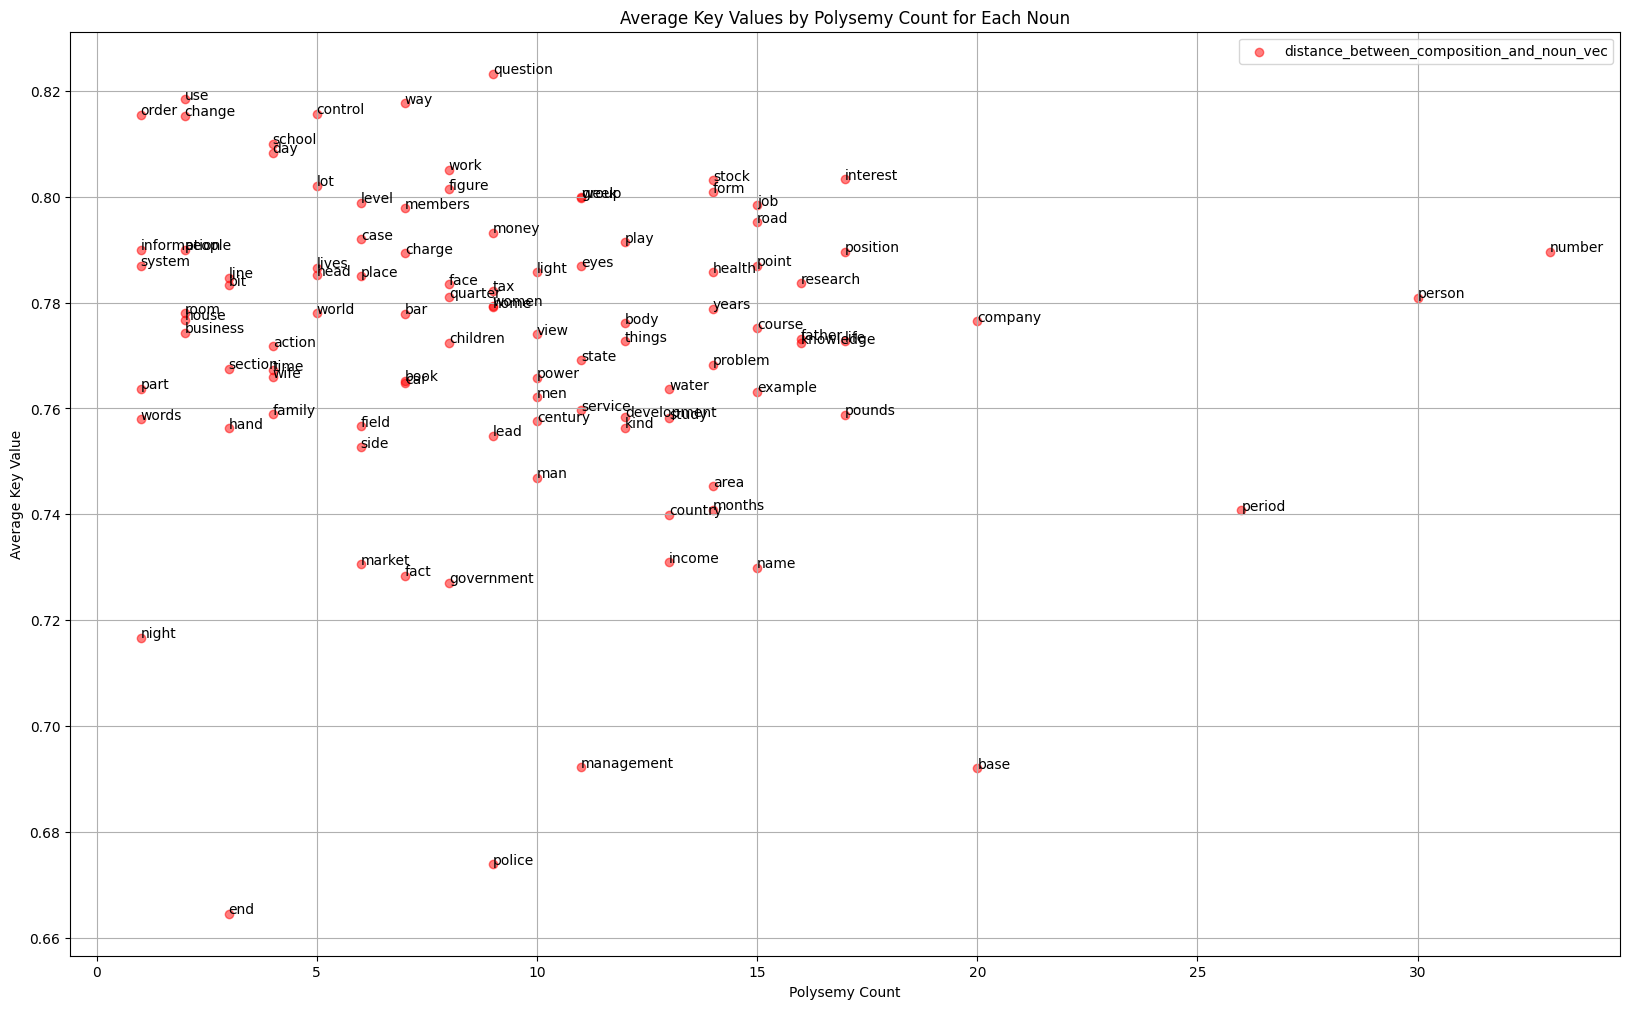

In [11]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def load_polysemy_data(filepath):
    """Loads polysemy counts from a JSON file."""
    with open(filepath, 'r') as file:
        polysemy_data = json.load(file)
    return {item[0]: item[1] for item in polysemy_data}  # Dict of word to polysemy count

def extract_and_average_values(directory, keys, polysemy_data):
    """Extracts and averages values from JSON files, correlating them with polysemy counts."""
    data_points = {key: {} for key in keys}  # Initialize with dict for each key
    labels = set()  # Use a set to avoid duplicate labels
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                for adj, nouns in data.items():
                    for noun, metrics in nouns.items():
                        
                        if noun in polysemy_data:
                            polysemy_count = polysemy_data[noun]
                            for key in keys:
                                if key in metrics:
                                    if noun not in data_points[key]:
                                        labels.add(noun)  # Add label in the order it's processed
                                        data_points[key][noun] = []
                                    data_points[key][noun].append(metrics[key])
                                    #labels.add(noun)
    # Now average the collected values for each noun
    averaged_data = {key: [] for key in keys}  # This will store the final averaged values
    for key, nouns in data_points.items():
        for noun, values in nouns.items():
            average_value = np.mean(values)
            polysemy_count = polysemy_data[noun]
            averaged_data[key].append((polysemy_count, average_value))

    return averaged_data, labels



polysemy_data = load_polysemy_data(polysemy_file)
data_points, labels = extract_and_average_values(directory, keys, polysemy_data)

# Plotting
plt.figure(figsize=(20, 12))
colors = ['r', 'g', 'b', 'y']  # Adjust as necessary
for i, key in enumerate(keys):
    x_vals, y_vals = zip(*data_points[key])
    plt.scatter(x_vals, y_vals, color=colors[i % len(colors)], label=f'{key}', alpha=0.5)
    # Label each point
    for j, label in enumerate(labels):
        plt.annotate(label, (x_vals[j], y_vals[j]))

plt.xlabel('Polysemy Count')
plt.ylabel('Average Key Value')
plt.title('Average Key Values by Polysemy Count for Each Noun')
plt.legend()
plt.grid(True)
plt.show()


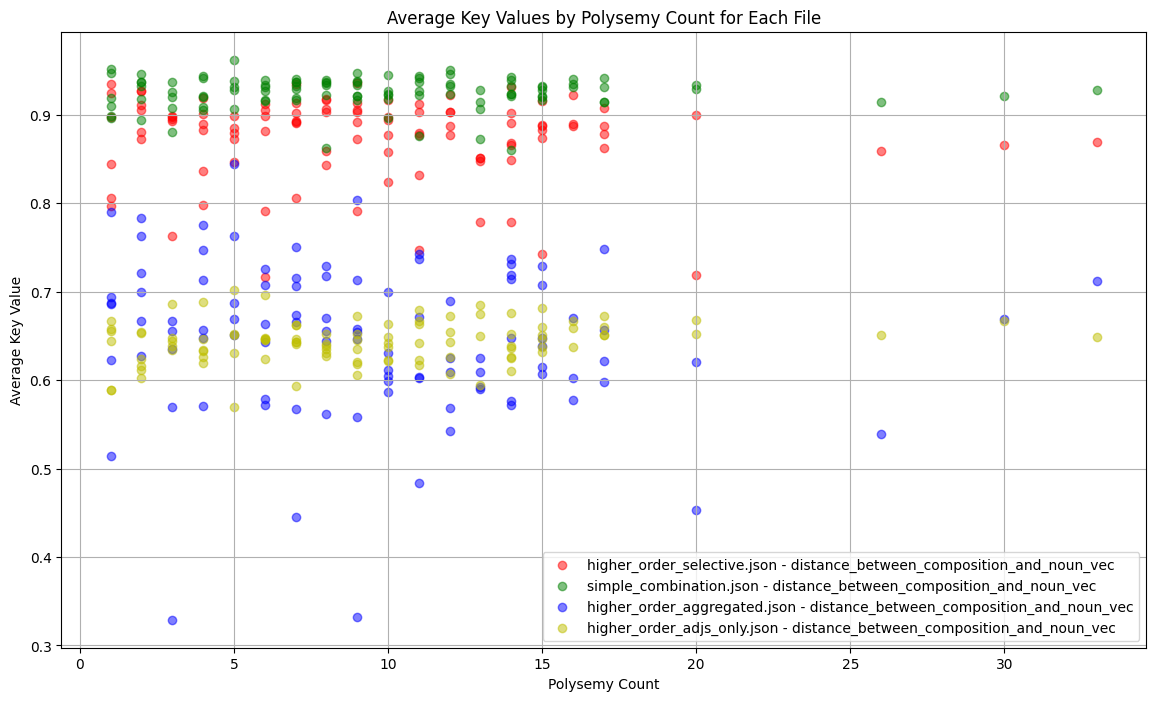

In [12]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def load_polysemy_data(filepath):
    """Loads polysemy counts from a JSON file."""
    with open(filepath, 'r') as file:
        polysemy_data = json.load(file)
    return {item[0]: item[1] for item in polysemy_data}  # Dict of word to polysemy count

def extract_and_average_values(directory, keys, polysemy_data):
    """Extracts and averages values from JSON files, correlating them with polysemy counts."""
    file_data = {}  # To store data separately for each file

    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                data_points = {key: {} for key in keys}  # Initialize data storage for this file
                for adj, nouns in data.items():
                    for noun, metrics in nouns.items():
                        if noun in polysemy_data:
                            for key in keys:
                                if key in metrics:
                                    if noun not in data_points[key]:
                                        data_points[key][noun] = []
                                    data_points[key][noun].append(metrics[key])

                # Calculate averages for this file and associate with polysemy count
                averaged_data = {key: [] for key in keys}
                for key, nouns in data_points.items():
                    for noun, values in nouns.items():
                        if noun in polysemy_data:
                            polysemy_count = polysemy_data[noun]  # Retrieve polysemy count here
                            average_value = np.mean(values)
                            averaged_data[key].append((polysemy_count, average_value))
                
                file_data[filename] = averaged_data  # Store averaged data under filename key

    return file_data



polysemy_data = load_polysemy_data(polysemy_file)
all_file_data = extract_and_average_values(directory, keys, polysemy_data)

# Plotting
plt.figure(figsize=(14, 8))
colors = ['r', 'g', 'b', 'y']  # Enough colors for each file, add more if needed
for i, (filename, data) in enumerate(all_file_data.items()):
    for key in keys:
        x_vals, y_vals = zip(*data[key])
        plt.scatter(x_vals, y_vals, color=colors[i % len(colors)], label=f'{filename} - {key}', alpha=0.5)

plt.xlabel('Polysemy Count')
plt.ylabel('Average Key Value')
plt.title('Average Key Values by Polysemy Count for Each File')
plt.legend()
plt.grid(True)
plt.show()


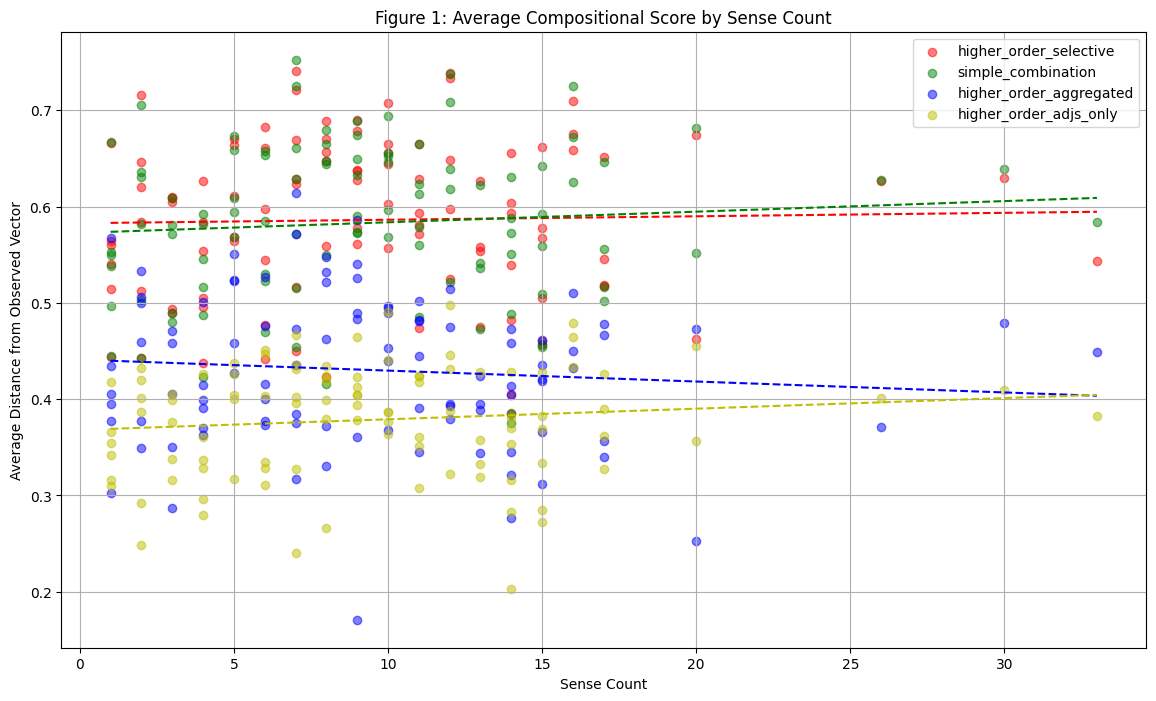

In [8]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def load_polysemy_data(filepath):
    """Loads polysemy counts from a JSON file."""
    with open(filepath, 'r') as file:
        polysemy_data = json.load(file)
    return {item[0]: item[1] for item in polysemy_data}

def extract_and_average_values(directory, keys, polysemy_data):
    """Extracts and averages values from JSON files, correlating them with polysemy counts."""
    file_data = {}
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                data_points = {key: {} for key in keys}
                for adj, nouns in data.items():
                    for noun, metrics in nouns.items():
                        if noun in polysemy_data:
                            for key in keys:
                                if key in metrics:
                                    if noun not in data_points[key]:
                                        data_points[key][noun] = []
                                    data_points[key][noun].append(metrics[key])

                averaged_data = {key: [] for key in keys}
                for key, nouns in data_points.items():
                    for noun, values in nouns.items():
                        if noun in polysemy_data:
                            polysemy_count = polysemy_data[noun]
                            average_value = np.mean(values)
                            averaged_data[key].append((polysemy_count, average_value))
                
                file_data[filename] = averaged_data
    return file_data

# Configuration and execution
polysemy_data = load_polysemy_data(polysemy_file)
all_file_data = extract_and_average_values(directory, keys, polysemy_data)

# Plotting and regression
plt.figure(figsize=(14, 8))
colors = ['r', 'g', 'b', 'y']
for i, (filename, data) in enumerate(all_file_data.items()):
    filename = filename.split('.')[0]
    for key in keys:
        x_vals, y_vals = zip(*data[key])
        plt.scatter(x_vals, y_vals, color=colors[i % len(colors)], label=f'{filename}', alpha=0.5)
        
          # Polynomial Regression
        z = np.polyfit(x_vals, y_vals, 1)  # Degree 2 polynomial
        p = np.poly1d(z)
        x_line = np.linspace(min(x_vals), max(x_vals), 100)
        plt.plot(x_line, p(x_line), color=colors[i % len(colors)], linestyle='dashed')

plt.xlabel('Sense Count')
plt.ylabel('Average Distance from Observed Vector')
plt.title('Figure 1: Average Compositional Score by Sense Count')
plt.legend()
plt.grid(True)
plt.show()


{'distance_between_composition_and_observed_phrase': [(11, 0.6285249257628726), (7, 0.7205850015990692), (30, 0.6293941243534791), (11, 0.5808153513694053), (10, 0.7072006370096837), (12, 0.7337311030597088), (15, 0.5669593373993531), (7, 0.7410733549417967), (10, 0.6445713552425637), (14, 0.5390070946054677), (11, 0.6650216605467989), (12, 0.5245377657868457), (7, 0.6290692742719174), (13, 0.5583275189354738), (8, 0.6562514169751275), (20, 0.6747846393601661), (6, 0.47709961380749133), (17, 0.5177211632155462), (14, 0.5932779623164366), (8, 0.5585926281126231), (4, 0.626929913400679), (13, 0.5536792819208791), (6, 0.6613342688365793), (33, 0.54324090145759), (9, 0.6787719722818589), (20, 0.4624991047743485), (3, 0.6104565349941713), (2, 0.716224865916716), (13, 0.6261111372022572), (1, 0.514703981672143), (12, 0.5971132462964135), (3, 0.493845268347446), (9, 0.6902437206010288), (3, 0.6094061560212144), (5, 0.5639689744658273), (13, 0.47545286208621806), (4, 0.5540684541990512), (1, 0

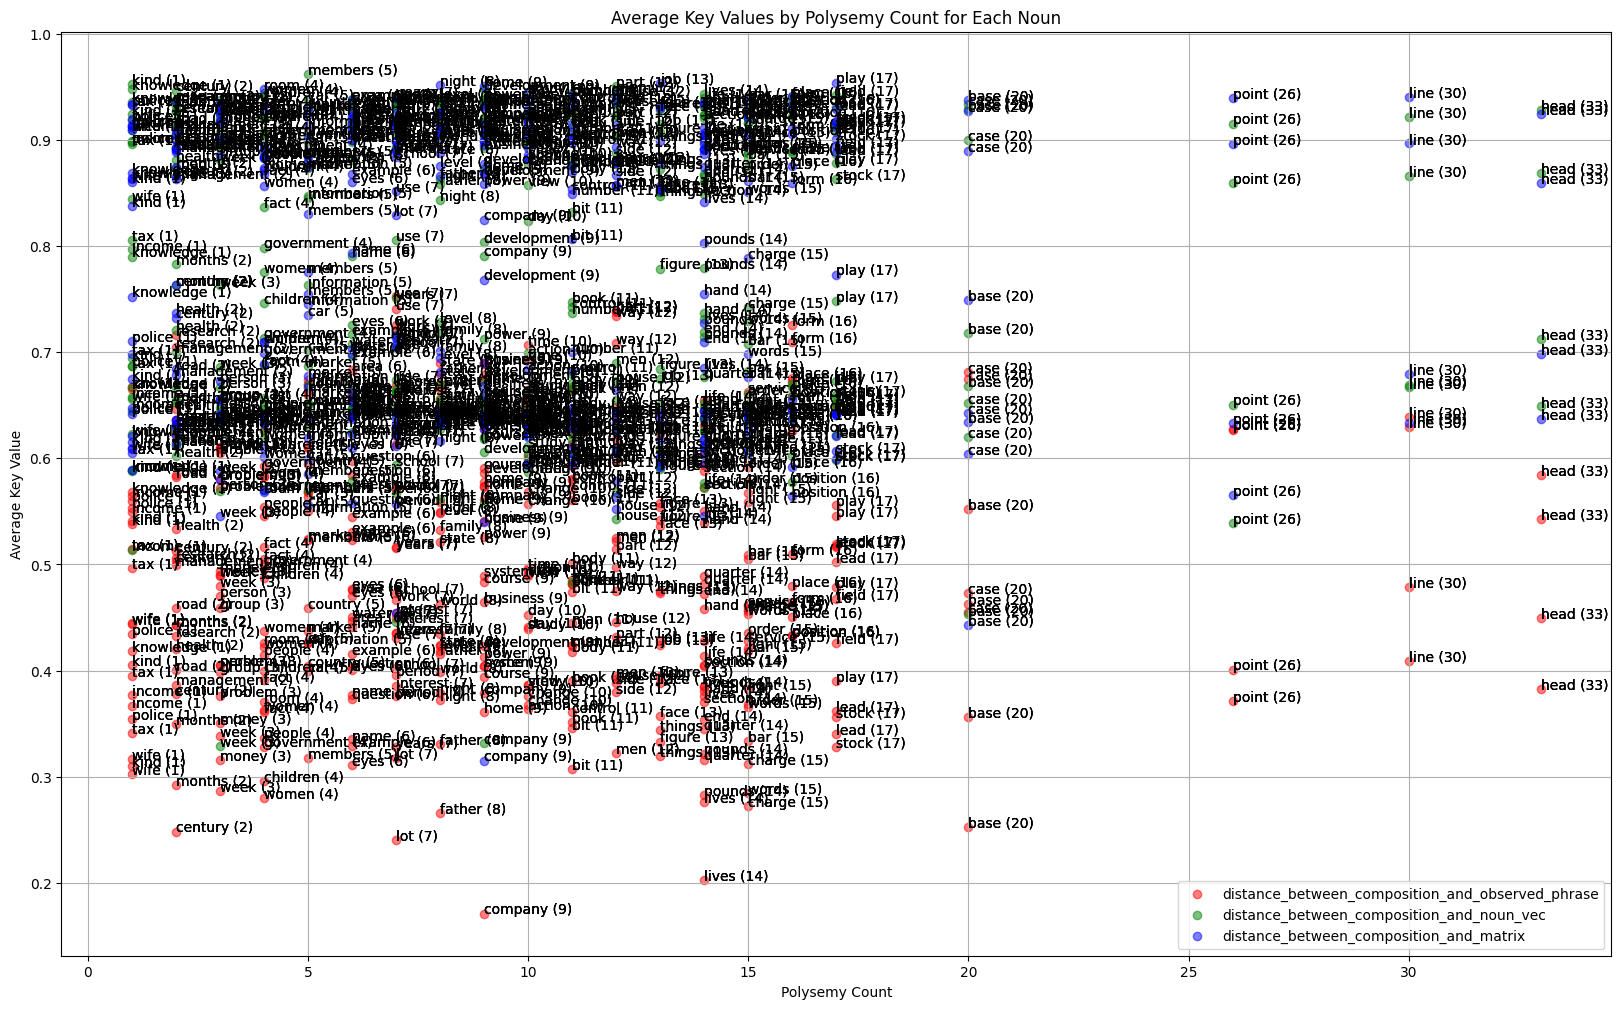

In [22]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def load_polysemy_data(filepath):
    """Loads polysemy counts from a JSON file."""
    with open(filepath, 'r') as file:
        polysemy_data = json.load(file)
    return {item[0]: item[1] for item in polysemy_data}  # Dict of word to polysemy count

def extract_and_average_values(directory, keys, polysemy_data):
    """Extracts and averages values from JSON files, correlating them with accurate polysemy counts."""
    data_points = {key: [] for key in keys}  # List to store data points for each key
    label_data = []  # List to store label and polysemy information for accurate labeling

    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                noun_aggregates = {key: {} for key in keys}  # Dictionary to aggregate noun values

                for adj, nouns in data.items():
                    for noun, metrics in nouns.items():
                        if noun in polysemy_data:
                            polysemy_count = polysemy_data[noun]
                            for key in keys:
                                if key in metrics:
                                    if noun not in noun_aggregates[key]:
                                        noun_aggregates[key][noun] = []
                                    noun_aggregates[key][noun].append(metrics[key])

                # Calculate averages for each noun and associate them with the correct polysemy count
                for key, nouns in noun_aggregates.items():
                    for noun, values in nouns.items():
                        average_value = np.mean(values)
                        data_points[key].append((polysemy_data[noun], average_value))
                        label_data.append((noun, polysemy_data[noun], average_value))

    return data_points, label_data



polysemy_data = load_polysemy_data(polysemy_file)
data_points, label_data = extract_and_average_values(directory, keys, polysemy_data)
print(data_points)


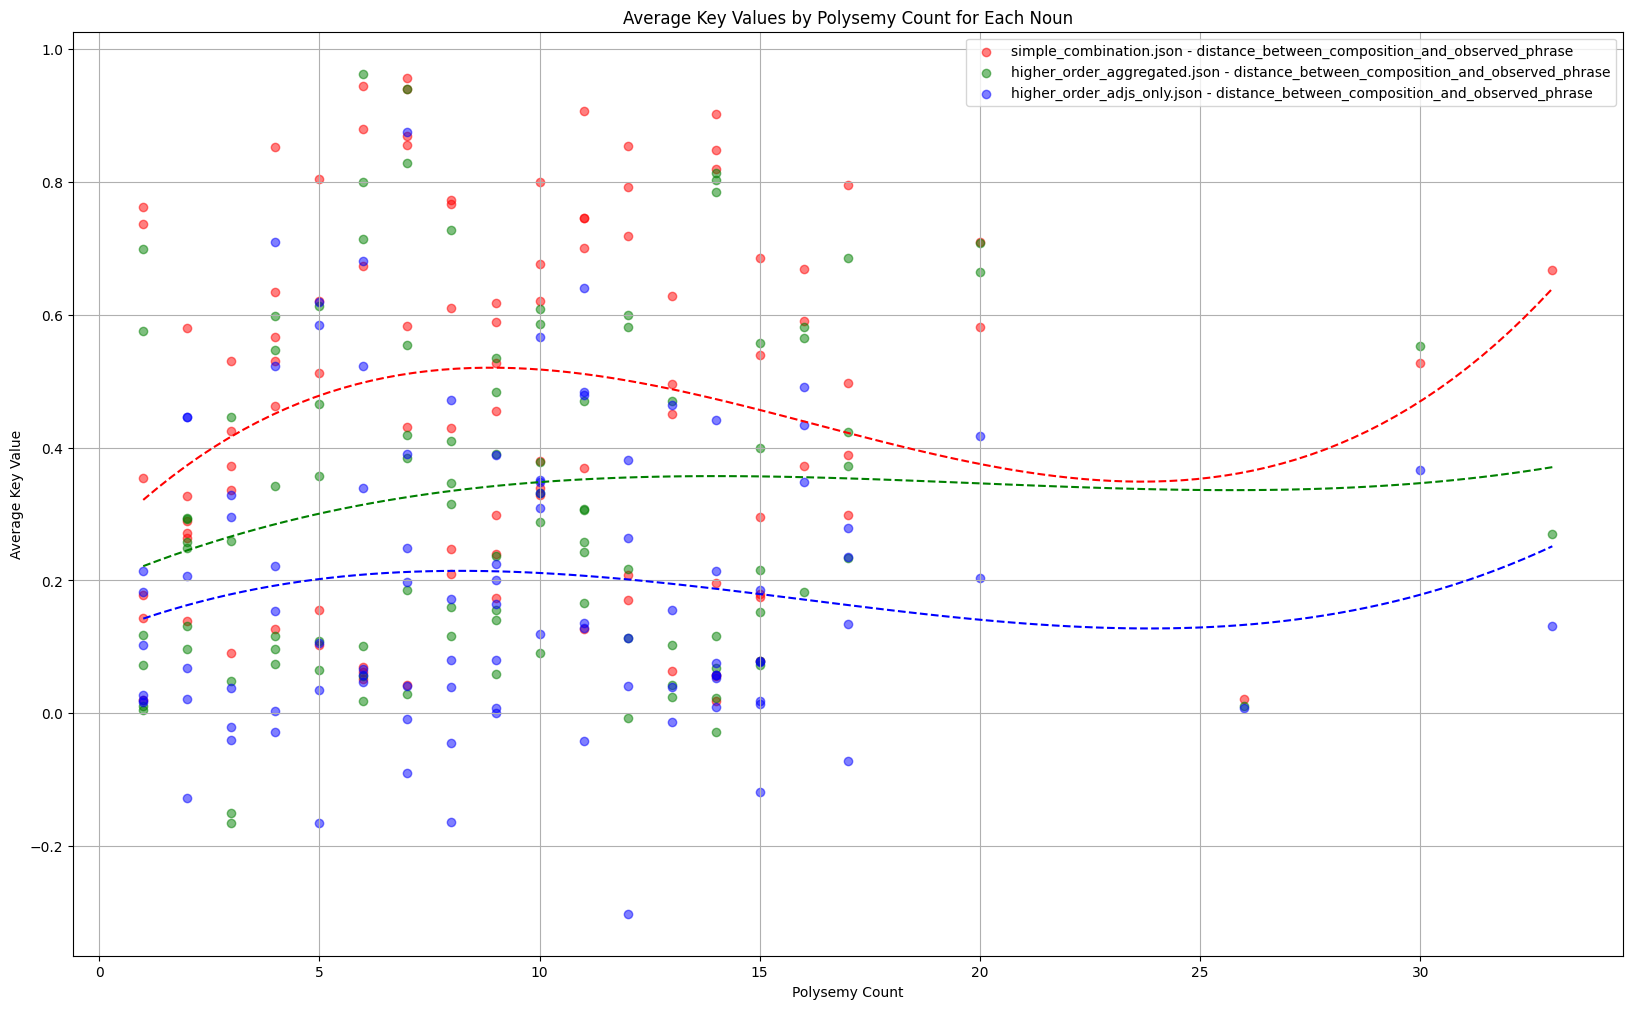

In [6]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def load_polysemy_data(filepath):
    """Loads polysemy counts from a JSON file."""
    with open(filepath, 'r') as file:
        polysemy_data = json.load(file)
    return {item[0]: item[1] for item in polysemy_data}

def extract_and_average_values(directory, keys, polysemy_data):
    """Extracts and averages values from JSON files, correlating them with accurate polysemy counts."""
    file_data = {}  # To store data separately for each file

    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                data_points = {key: [] for key in keys}

                for adj, nouns in data.items():
                    for noun, metrics in nouns.items():
                        if noun in polysemy_data:
                            polysemy_count = polysemy_data[noun]
                            for key in keys:
                                if key in metrics:
                                    if not any(noun == label for label, _, _ in data_points[key]):
                                        data_points[key].append((noun, polysemy_count, np.mean(metrics[key])))

            file_data[filename] = data_points

    return file_data, polysemy_data


file_data, polysemy_data = extract_and_average_values(directory, keys, polysemy_data)

# Plotting
plt.figure(figsize=(20, 12))
colors = ['r', 'g', 'b', 'y']  # Adjust as necessary for number of files
file_color = iter(colors)
counter = 0
for filename, data in file_data.items():
    
    counter += 1
    if counter == 1: continue
    current_color = next(file_color)
    for key in keys:
        x_vals, y_vals = zip(*[(polysemy, val) for _, polysemy, val in data[key]])
        plt.scatter(x_vals, y_vals, color=current_color, label=f'{filename} - {key}', alpha=0.5)

        # Polynomial Regression
        z = np.polyfit(x_vals, y_vals, 3)  # Degree 2 polynomial
        p = np.poly1d(z)
        x_line = np.linspace(min(x_vals), max(x_vals), 100)
        plt.plot(x_line, p(x_line), color=current_color, linestyle='dashed')

        # Annotate each point
        """for label, x, y in data[key]:
            plt.annotate(label, (x, y))"""

plt.xlabel('Polysemy Count')
plt.ylabel('Average Key Value')
plt.title('Average Key Values by Polysemy Count for Each Noun')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
import os
import json
import numpy as np

def extract_values_from_json_files(directory, keys):
    """Extracts specified nested keys from all JSON files in the given directory and organizes them by file.

    Parameters:
        directory (str): The path to the directory containing JSON files.
        keys (list of str): The nested keys to extract and average values from.

    Returns:
        dict: A dictionary containing the organized and averaged values for each key, structured by file.
    """
    structured = {key: {} for key in keys}  # Dictionary to organize data by key and file

    # List all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.json'):  # Ensure the file is a JSON file
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                # Initialize temporary storage for this file's values under each key
                temp_values = {key: [] for key in keys}
                
                # Traverse through nested dictionary and collect values
                for adj_key, noun_dict in data.items():
                    for noun_key, metrics in noun_dict.items():
                        for key in keys:
                            if key in metrics:
                                temp_values[key].append(metrics[key])

                # Store averages in structured output under each key
                for key in keys:
                    file_id = filename.split('.')[0]  # Filename without extension
                    if file_id not in structured[key]:
                        structured[key][file_id] = []  # Initialize list if key is not present
                    structured[key][file_id].append(np.mean(temp_values[key]) if temp_values[key] else None)

    return structured

structured_data = extract_values_from_json_files(directory, keys)

# Printing structured data in a readable format
for key, file_data in structured_data.items():
    print(f"Data for {key}:")
    for file_id, values in file_data.items():
        print(f"  {file_id}: {values}")


Data for distance_between_composition_and_observed_phrase:
  higher_order_selective: [0.5979015712239252]
  simple_combination: [0.5949857314398764]
  higher_order_aggregated: [0.4377936509909905]
  higher_order_adjs_only: [0.38703459037914084]
Data for distance_between_composition_and_noun_vec:
  higher_order_selective: [0.874497472153489]
  simple_combination: [0.9251198147211181]
  higher_order_aggregated: [0.6472855748158015]
  higher_order_adjs_only: [0.6433072220021537]
Data for distance_between_composition_and_matrix:
  higher_order_selective: [0.8767668113208287]
  simple_combination: [0.915991343228104]
  higher_order_aggregated: [0.645175260153522]
  higher_order_adjs_only: [0.6275618657636615]


In [39]:
import os
import json
import numpy as np

def load_polysemy_and_frequency_data(filepath):
    """Loads polysemy counts and frequency data from a JSON file."""
    with open(filepath, 'r') as file:
        data = json.load(file)
    return {item[0]: {'polysemy': item[1], 'frequency': item[2]} for item in data}

def extract_values_and_sort_by_polysemy(directory, key, polysemy_data):
    """Extracts values from JSON files and organizes them by word, sorted by polysemy count."""
    word_data = {}

    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                for adj, nouns in data.items():
                    for noun, metrics in nouns.items():
                        if noun in polysemy_data:
                            
                            if key in metrics:
                                score = metrics[key]
                                
                                if noun not in word_data:
                                    word_data[noun] = {
                                        'polysemy': polysemy_data[noun]['polysemy'],
                                        'frequency': polysemy_data[noun]['frequency'],
                                        'scores': []
                                    }
                                word_data[noun]['scores'].append(score)

    # Sort words by polysemy count, descending
    sorted_words = sorted(word_data.items(), key=lambda x: x[1]['polysemy'], reverse=True)
    sorted_word_data = {word: info for word, info in sorted_words}

    return sorted_word_data



polysemy_data = load_polysemy_and_frequency_data(polysemy_file)
sorted_word_data = extract_values_and_sort_by_polysemy(directory, keys[0], polysemy_data)
# Print the sorted data
for word, details in sorted_word_data.items():
    print(f"{word}: Polysemy: {details['polysemy']}, Frequency: {details['frequency']}, Average Score: {details['scores'] if details['scores'] else 'No data'}")


head: Polysemy: 33, Frequency: 30772, Average Score: [0.5898936250637076, 0.565780057975315, 0.8815313550944224, 0.1440210643186558, 0.3509414617221958, 0.5999259636199188, 0.41400627012724517, 0.6005057373037269, 0.36156728979140773, 0.07305585822794325, 0.015467310521696915, 0.23907544817222068, 0.5617396288165952, 0.3071561879038692, 0.7280209664197737, 0.4049394473317117, 0.7464647750818203, 0.5790927641034963, 0.37979938844605593, 0.7259249910269061, 0.2623374043965285, 0.8456525123137623, 0.3981824954641652, 0.28002624284431354, 0.20698220222989155, 0.9144483718994457, 0.7125743118036676, 0.7739921085956121, 0.41104112649711, 0.7941316261721079, 0.7850392235586623, 0.5490902409178268, 0.6259907158539726, 0.5967146973057122, 0.6147307672472007, 0.9004253425467341, 0.5960623220483615, 0.8030686672478968, 0.8161902556314312, 0.8536084411534824, 0.4952980118024832, 0.2500692798601281, 0.7531581136894074, 0.7852985906133215, 0.6435812767152524, 0.4256870915491158, 0.658863348433784, 0

In [37]:
# Configuration and execution
directory = 'data/experiment/results'
polysemy_file = 'data/experiment/nn_final_counts.json'
keys = ['distance_between_composition_and_observed_phrase']
#keys = ["distance_between_composition_and_noun_vec"]

In [38]:
import os
import json

def load_polysemy_and_frequency_data(filepath):
    """Loads polysemy counts and frequency data from a JSON file."""
    with open(filepath, 'r') as file:
        data = json.load(file)
    return {item[0]: {'polysemy': item[1], 'frequency': item[2]} for item in data}

def extract_values_and_store_by_file(directory, key, polysemy_data):
    """Extracts values from JSON files and organizes them by word, associating each score with the originating file."""
    word_data = {}

    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            file_key = filename.split('.')[0]  # Use the part of the filename before the extension as the key
            with open(filepath, 'r') as file:
                data = json.load(file)
                for adj, nouns in data.items():
                    for noun, metrics in nouns.items():
                        if noun in polysemy_data:
                            if key in metrics:
                                score = metrics[key]
                                if noun not in word_data:
                                    word_data[noun] = {
                                        'polysemy': polysemy_data[noun]['polysemy'],
                                        'frequency': polysemy_data[noun]['frequency'],
                                        'scores': {}
                                    }
                                if file_key not in word_data[noun]['scores']:
                                    word_data[noun]['scores'][file_key] = []
                                word_data[noun]['scores'][file_key].append(score)

    # Sort words by polysemy count, descending
    sorted_words = sorted(word_data.items(), key=lambda x: x[1]['polysemy'], reverse=True)
    sorted_word_data = {word: info for word, info in sorted_words}

    return sorted_word_data

# Usage


polysemy_data = load_polysemy_and_frequency_data(polysemy_file)
sorted_word_data = extract_values_and_store_by_file(directory, keys[0], polysemy_data)

# Print the sorted data
for word, details in sorted_word_data.items():
    print(f"{word}: Polysemy: {details['polysemy']}, Frequency: {details['frequency']}, Scores by File: {details['scores']}")


head: Polysemy: 33, Frequency: 30772, Scores by File: {'higher_order_selective': [0.5898936250637076, 0.565780057975315, 0.8815313550944224, 0.1440210643186558, 0.3509414617221958, 0.5999259636199188, 0.41400627012724517, 0.6005057373037269, 0.36156728979140773, 0.07305585822794325, 0.015467310521696915, 0.23907544817222068, 0.5617396288165952, 0.3071561879038692, 0.7280209664197737, 0.4049394473317117, 0.7464647750818203, 0.5790927641034963, 0.37979938844605593, 0.7259249910269061, 0.2623374043965285, 0.8456525123137623, 0.3981824954641652, 0.28002624284431354, 0.20698220222989155, 0.9144483718994457, 0.7125743118036676, 0.7739921085956121, 0.41104112649711, 0.7941316261721079, 0.7850392235586623, 0.5490902409178268, 0.6259907158539726, 0.5967146973057122, 0.6147307672472007, 0.9004253425467341, 0.5960623220483615, 0.8030686672478968, 0.8161902556314312, 0.8536084411534824, 0.4952980118024832, 0.2500692798601281, 0.7531581136894074, 0.7852985906133215, 0.6435812767152524, 0.4256870915